In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generic imports
import matplotlib.pyplot as plt
import numpy as np
import glob, datetime, os

from astropy.wcs import WCS
from astropy.io import fits as fits

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import astroscrappy

# Disable some annoying warnings from astropy
import warnings
from astropy.wcs import FITSFixedWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)

# Our sub-modules
from stdpipe import astrometry, photometry, catalogs, cutouts, templates, subtraction, plots, pipeline, utils


# Simple catalogue-based pipeline using lower-level functions


It shows how to use the lower-level functions from the package to construct simple pipeline that performs astrometric refinement and photometric calibration of the frame, and then detects transients by comparing the detected objects with various catalogues. 

Other notebooks will show how to use higher-level wrappers for these common 

The code below assumes that the image is already pre-processed (i.e. dark-subtracted and flat-fielded) and roughly astrometrically calibrated.

Processing 20200306225139-338-RA.fits: filter N, 1056x1024
Done masking cosmics: 95 pixels masked
60 objects found
7 objects not matched with reference catalogue
1 of them are unflagged
1 remains after matching with PanSTARRS DR1
1 remains after matching with USNO-B1
1 remains after matching with GSC 2.2
1 remains after matching with SkyBot
1 remains after matching with NED
1 candidate(s) remaining
id 21: 14.0326 mag at 198.556 11.2698


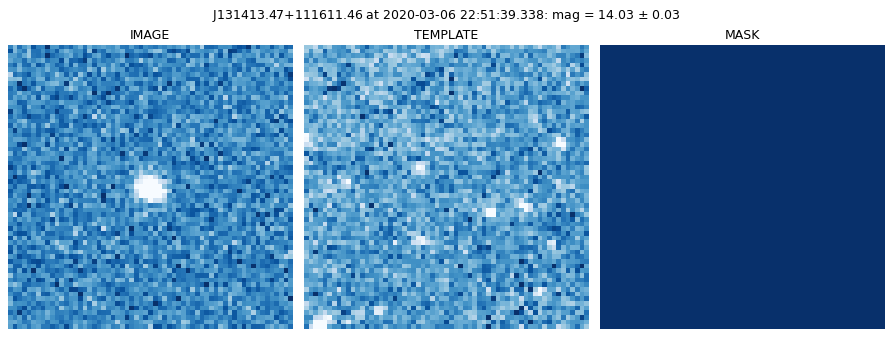

In [2]:
# FRAM pre-processed image containing GRB200306C, white light
filename = '../tests/20200306225139-338-RA.fits'

header = fits.getheader(filename)
image = fits.getdata(filename).astype(np.double)

fname = header['FILTER'].strip()
time = Time(header['DATE-OBS'])

print('Processing %s: filter %s, %dx%d' % (os.path.split(filename)[1], fname, image.shape[1], image.shape[0]))

# Create mask of bad pixels
mask = image > 50000 # Rough saturation level

# Cosmics
cmask, cimage = astroscrappy.detect_cosmics(image, mask, verbose=False)
print('Done masking cosmics: %d pixels masked' % np.sum(cmask))
mask |= cmask

# Extract objects
obj = photometry.get_objects_sextractor(image, mask=mask, r0=2, aper=5.0)
obj['id'] = np.arange(len(obj)) # Sort of unique identifier for the objects
obj['time'] = time
print(len(obj), 'objects found')

# TODO: perform proper accurate photometry here to improve the measurements

# Initial WCS from FITS header
wcs = WCS(header)

obj['ra'],obj['dec'] = wcs.all_pix2world(obj['x'], obj['y'], 0)

ra0,dec0,sr0 = astrometry.get_frame_center(wcs=wcs, width=image.shape[1], height=image.shape[0])
pixscale = np.hypot(wcs.pixel_scale_matrix[0,0], wcs.pixel_scale_matrix[0,1])

# Get reference catalogue for astrometric/photometric match, so not too deep
cat = catalogs.get_cat_vizier(ra0, dec0, sr0, 'ps1', filters={'rmag':'<17'})

# Initial loose match for refining the WCS
for iter in range(3):
    # Simple positional matching
    # wcs = refine_wcs(obj, cat, order=2, sr=20.0*pixscale, update=True)
    # Matching involving photometric information
    m = photometry.match(obj['ra'], obj['dec'], obj['mag'], np.hypot(obj['magerr'], 0.02), obj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['R'], sr=20.0*pixscale)
    if np.sum(m['idx']) < 10:
        print('Too few good matches, cannot refine WCS')
        break
        
    # Fit WCS with SIP polynomial, second order
    wcs = astrometry.refine_wcs(obj[m['oidx']][m['idx']], cat[m['cidx']][m['idx']], order=2, match=False)
    
    # Update sky coordinates of detected objects
    obj['ra'],obj['dec'] = wcs.all_pix2world(obj['x'], obj['y'], 0)

# Update WCS info in the header
astrometry.clear_wcs(header, remove_comments=True, remove_underscored=True, remove_history=True)
header.update(wcs.to_header(relax=True))

# Positional matching radius, assuming FWHM is more or less constant over the frame
sr = np.median(obj['fwhm'])/2 * pixscale
sr = max(1/3600, sr)

# Photometric calibration
m = photometry.match(obj['ra'], obj['dec'], obj['mag'], np.hypot(obj['magerr'], 0.02), obj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['R'], sr=sr, cat_color=cat['B']-cat['V'], obj_x=obj['x'], obj_y=obj['y'])
obj['mag_calib'] = obj['mag'] + m['zero_fn'](obj['x'], obj['y'])

# Secondary loose match for exclusion of catalogue objects
mc = photometry.match(obj['ra'], obj['dec'], obj['mag'], np.hypot(obj['magerr'], 0.02), obj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['R'], sr=2.0*sr)

# Initial candidates - the objects not matched with the catalogue
cand_idx = ~np.in1d(np.arange(len(obj['x'])), mc['oidx'])
print(np.sum(cand_idx), 'objects not matched with reference catalogue')

# Filter out flagged objects (saturated, cosmics, blends, etc)
cand_idx &= obj['flags'] == 0
print(np.sum(cand_idx), 'of them are unflagged')

# Cross-match with photometric catalogues using XMatch
for catname in ['ps1', 'usnob1', 'gsc']:
    if not np.any(cand_idx):
        break

    xcat = catalogs.xmatch_objects(obj[cand_idx], catname, sr)
    if xcat and len(xcat):
        cand_idx &= ~np.in1d(obj['id'], xcat['id'])

    print(np.sum(cand_idx), 'remains after matching with', catalogs.catalogs.get(catname)['name'])

# Check SkyBot for solar system objects
if np.any(cand_idx):
    xcat = catalogs.xmatch_skybot(obj[cand_idx], time=time)
    if xcat and len(xcat):
        cand_idx &= ~np.in1d(obj['id'], xcat['id'])
    print(np.sum(cand_idx), 'remains after matching with SkyBot')

# Check NED for galaxies
if np.any(cand_idx):
    xcat = catalogs.xmatch_ned(obj[cand_idx], 2*sr)
    if xcat and len(xcat):
        cand_idx &= ~np.in1d(obj['id'], xcat['id'])
    print(np.sum(cand_idx), 'remains after matching with NED')

print(np.sum(cand_idx), 'candidate(s) remaining')

# Display cutouts
bg = photometry.get_background(image, mask=mask)

for cand in obj[cand_idx]:
    print('id %d: %g mag at %g %g' % (cand['id'], cand['mag_calib'], cand['ra'], cand['dec']))
    cutout = cutouts.get_cutout(image, cand, 30, mask=mask, bg=bg, header=header, filename=filename)
    # We may directly download the template image for this cutout from HiPS server
    cutout['template'] = templates.get_hips_image('PanSTARRS/DR1/r', header=cutout['header'])[0]
    
    # We do not have difference image, so it will only display original one, template and mask
    plots.plot_cutout(cutout)
    plt.show()

# Plot photometric solution

<AxesSubplot:title={'center':'color term = -0.14'}, xlabel='Catalogue color', ylabel='Model - Instrumental'>

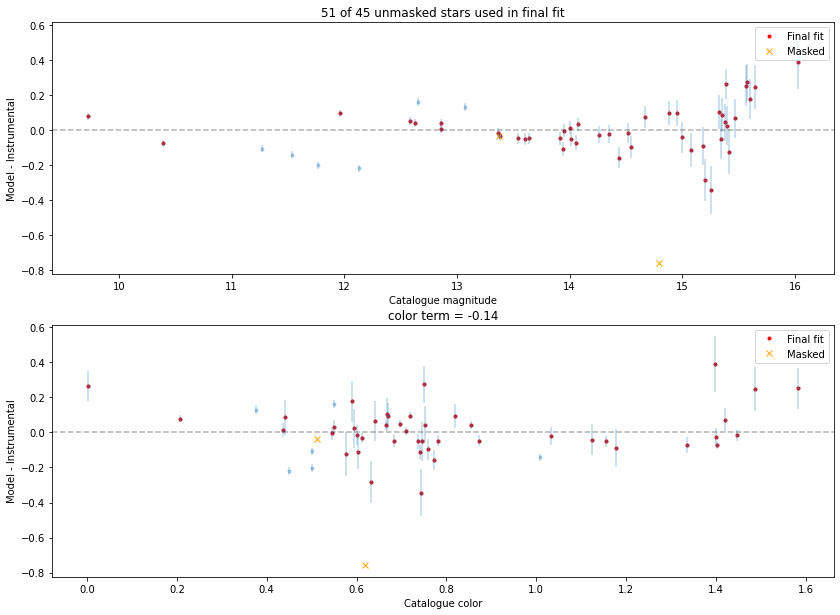

In [3]:
plt.subplot(211)
plots.plot_photometric_match(m)

plt.subplot(212)
plots.plot_photometric_match(m, mode='color')

Text(0.5, 1.0, 'All detected objects')

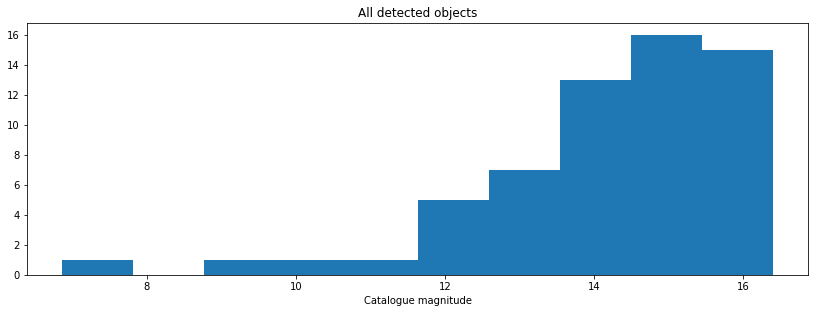

In [4]:
plt.subplot(211)
plt.hist(obj['mag_calib']);
plt.xlabel('Catalogue magnitude')
plt.title('All detected objects')

# Plot astrometric residuals

<AxesSubplot:title={'center':'45 stars: mean displacement 0.3 arcsec, median 0.2 arcsec'}>

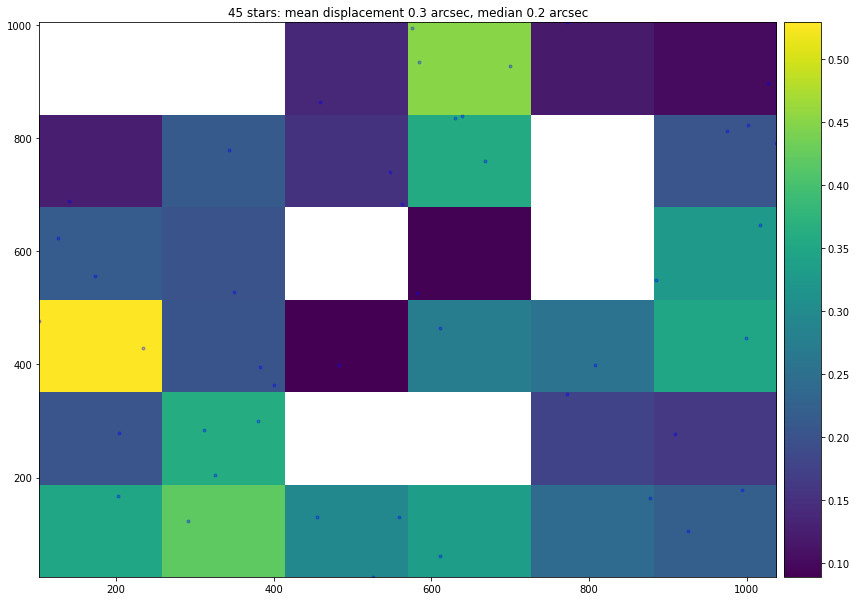

In [5]:
plots.plot_photometric_match(m, mode='dist', show_dots=True, bins=6)

# Original image

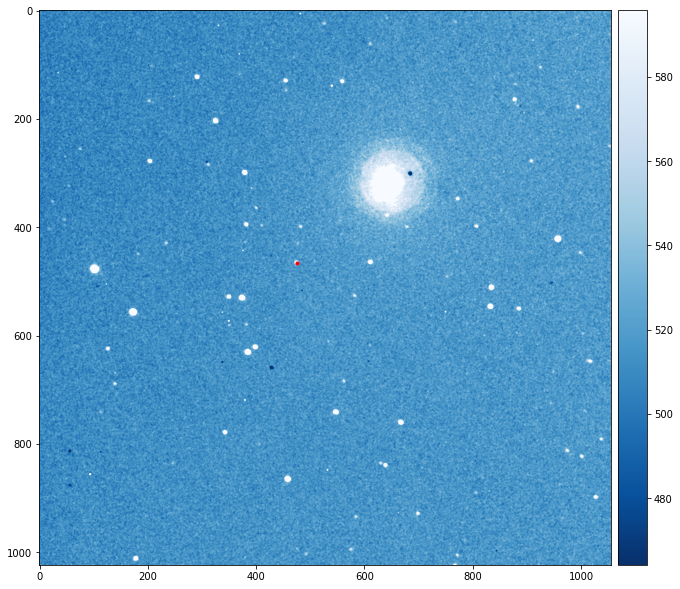

In [6]:
plots.imshow(image, cmap='Blues_r')
plt.plot(obj['x'][cand_idx], obj['y'][cand_idx], 'r.')

# Template image from PanSTARRS

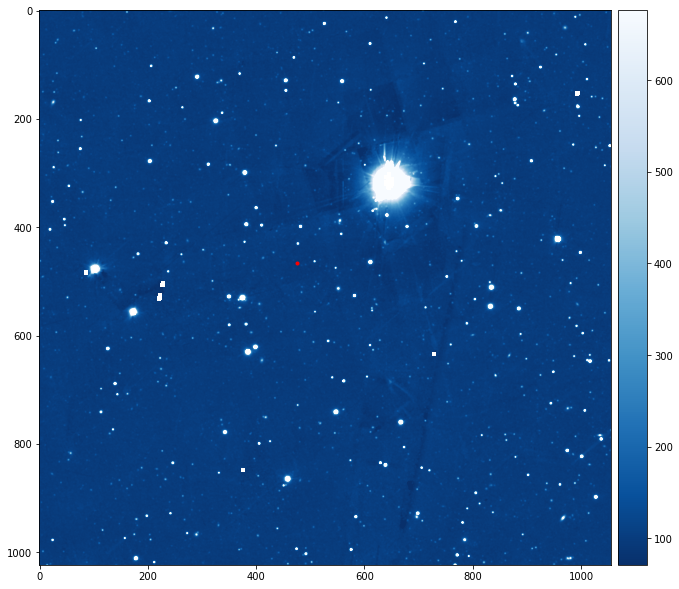

In [7]:
# We may get rough template from fits2hips service already pre-projected to our WCS 
tmpl,tmplhdr = templates.get_hips_image('PanSTARRS/DR1/r', header=header)

plots.imshow(tmpl, cmap='Blues_r')
plt.plot(obj['x'][cand_idx], obj['y'][cand_idx], 'r.')

# Subtract the images!

HiPS images have some fraction of bad pixels (saturated etc) masked and set to NaNs, but not all - most probably that's due to some peculiartiies of rebinning. Proper masking is important for image subtraction, so we may more or less fix it by masking the centers of stars above certain brightness.

Catalogue saturates at magnitude 15.2785


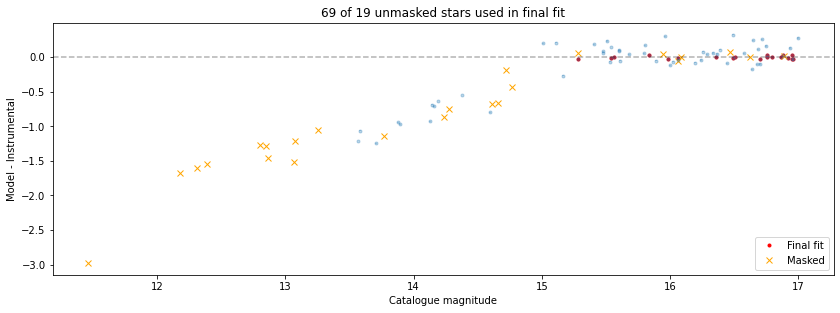

Text(0.5, 1.0, 'Final mask for the template')

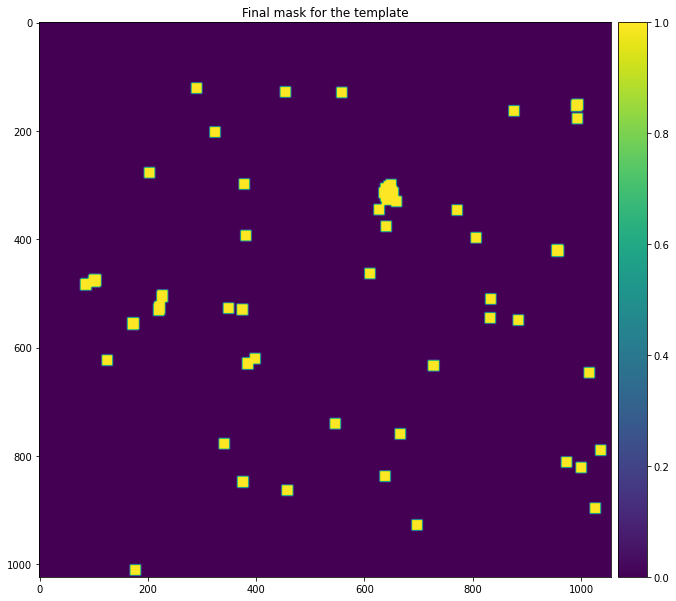

In [8]:
from scipy.ndimage import binary_dilation

tmask = ~np.isfinite(tmpl)

tobj = photometry.get_objects_sextractor(tmpl, mask=tmask, sn=3, wcs=wcs, aper=3)

m_tmpl = photometry.match(tobj['ra'], tobj['dec'], tobj['mag'], tobj['magerr'], tobj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['rmag'], cat_magerr=cat['e_rmag'], cat_saturation=13, sr=1/3600)

tmpl_saturation = np.min(cat[m_tmpl['cidx']][m_tmpl['idx']]['rmag'])

print('Catalogue saturates at magnitude', tmpl_saturation)

plt.subplot(211)
plots.plot_photometric_match(m_tmpl)
plt.show()

cx, cy = wcs.all_world2pix(cat['RAJ2000'], cat['DEJ2000'], 0)
tidx = cat['e_rmag'].mask
tidx |= cat['rmag'] < tmpl_saturation
tidx &= (cx > 1) & (cx < image.shape[1] - 2)
tidx &= (cy > 1) & (cy < image.shape[0] - 2)

tmask[cy[tidx].astype(np.int), cx[tidx].astype(np.int)] = True

# We may also dilate the mask a bit to better cover saturated regions
kernel = np.ones([20, 20])
tmask = binary_dilation(tmask, kernel)

plots.imshow(tmask)
plt.title('Final mask for the template')

In [9]:
# Now we should get unmasked template stars in order to estimate template FWHM
tobj = photometry.get_objects_sextractor(tmpl, mask=tmask, sn=10)
tobj = tobj[tobj['flags'] == 0]

# ..and finally do the subtraction!
diff,conv,sdiff,ediff = subtraction.run_hotpants(image, tmpl, mask=mask|tmask, template_mask=tmask, image_gain=1.0, get_convolved=True, get_scaled=True, get_noise=True, verbose=True, image_fwhm=np.median(obj['fwhm']), template_fwhm=np.median(tobj['fwhm']), extra={'c':'t', 'ko':2, 'bgo':4})

Will run HOTPANTS like that:
hotpants -inim /tmp/hotpants/image.fits -tmplim /tmp/hotpants/template.fits -outim /tmp/hotpants/out.fits -imi /tmp/hotpants/imask.fits -tmi /tmp/hotpants/tmask.fits -il -150.02692514273033 -iu 48317.45899443311 -tl -68.78288 -tu 37281.7 -n i -allm -ng 3 6 0.814424599565218 4 1.628849199130436 2 3.257698398260872 -r 21 -rss 49 -ig 1.0 -c t -ko 2 -bgo 4
HOTPANTS run succeeded


Will run SExtractor like that:
/opt/local/bin/sex /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sex625ehlwu/image.fits -VERBOSE_TYPE QUIET -DETECT_MINAREA 5 -GAIN 1 -DETECT_THRESH 2.0 -WEIGHT_TYPE MAP_RMS -MASK_TYPE NONE -WEIGHT_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sex625ehlwu/errors.fits -FLAG_IMAGE /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sex625ehlwu/flags.fits -PHOT_APERTURES 6.0 -PARAMETERS_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sex625ehlwu/cfg.param -CATALOG_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sex625ehlwu/out.cat -CATALOG_TYPE FITS_LDAC -FILTER Y -FILTER_NAME /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/sex625ehlwu/kernel.txt -STARNNW_NAME /opt/local/share/source-extractor/default.nnw
SExtractor run succeeded


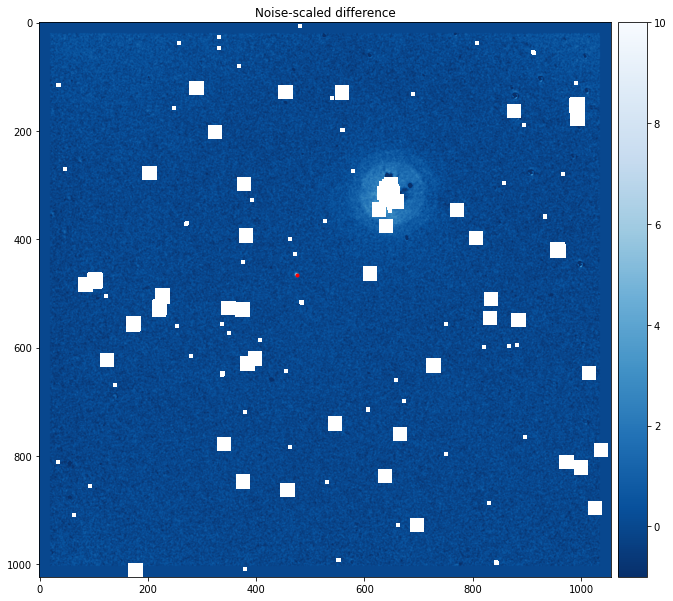

In [10]:
sdiff[mask|tmask] = np.nan
plots.imshow(sdiff, vmin=-1, vmax=10, cmap='Blues_r')
plt.title('Noise-scaled difference')

# We may now run object detection on difference image using noise model returned by HOTPANTS
sobj = photometry.get_objects_sextractor(diff, mask=mask|tmask, err=ediff, r0=np.median(obj['fwhm'])/2, sn=3, edge=50, extra_params=['CLASS_STAR'], extra_opts={'STARNNW_NAME': '/opt/local/share/source-extractor/default.nnw'}, verbose=True)
sobj = sobj[sobj['flags'] == 0]
# if we wish, we may even filter out some objects that SExtractor does not consider stellar-like enough
# sobj = sobj[sobj['CLASS_STAR'] < 0.5]

plt.plot(sobj['x'], sobj['y'], 'r.')

0 mag 14.29096314426614 at 475.18872 465.57504 - 198.55614917454204 11.269853224562922


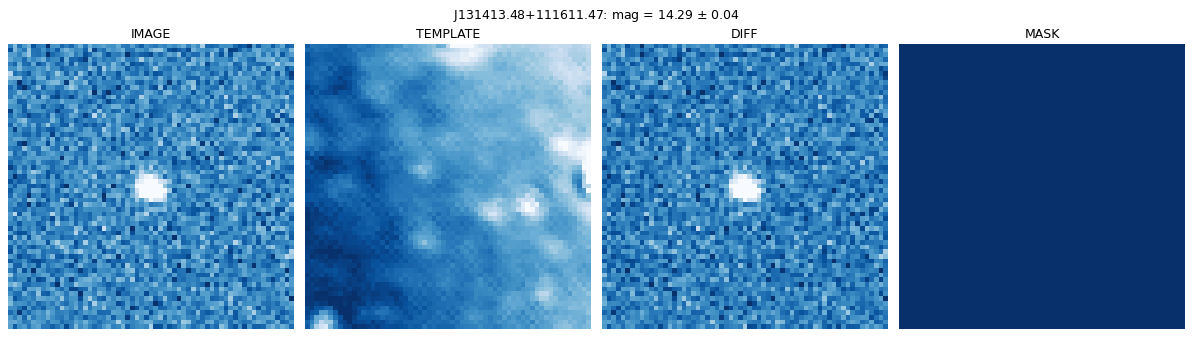

In [11]:
# And now we may check the cutouts around the transients detected by image subtraction

sobj['id'] = np.arange(len(sobj))
sobj['mag_calib'] = sobj['mag'] + m['zero_fn'](sobj['x'], sobj['y'])
sobj['ra'],sobj['dec'] = wcs.all_pix2world(sobj['x'], sobj['y'], 0)

for cand in sobj:
    print(cand['id'], 'mag', cand['mag_calib'], 'at', cand['x'], cand['y'], '-', cand['ra'], cand['dec'])
    cutout = cutouts.get_cutout(image, cand, 30, mask=mask|tmask, bg=bg, diff=diff, template=conv, header=header, filename=filename)

    plots.plot_cutout(cutout, nplots=4)
    plt.show()
